In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ***Análisis y modelo predictivo (Alpha vs Betha)***

### ***1. CARGA DE DATOS***

In [2]:
df = pd.read_csv('dataset_alpha_betha.csv')

### ***2. LIMPIEZA Y PREPROCESAMIENTO***

In [3]:
df = df.drop('autoID', axis=1)

df['Demand'] = pd.to_numeric(df['Demand'], errors='coerce')
df['Demand'] = df['Demand'].fillna(df['Demand'].median())

le = LabelEncoder()
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    if col != 'Class':
        df[col] = le.fit_transform(df[col])

df['Class'] = le.fit_transform(df['Class'])

### ***3. DIVISIÓN DE DATOS***

In [4]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### ***4. ENTRENAMIENTO DEL MODELO***

In [6]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### ***5. EVALUACIÓN***

In [7]:
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7977288857345636
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.66      0.48      0.56       373

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.71      1409
weighted avg       0.79      0.80      0.79      1409



### ***6. PREDICCIÓN PARA 'to_predict.csv'***

In [8]:
df_predict = pd.read_csv('to_predict.csv')
ids = df_predict['autoID']
X_to_predict = df_predict.drop(['autoID', 'Demand', 'Class'], axis=1)

In [9]:
for col in X_to_predict.select_dtypes(include=['object']).columns:
    X_to_predict[col] = le.fit_transform(X_to_predict[col])

In [10]:
X_to_predict['Demand'] = 0 
X_to_predict = scaler.transform(X_to_predict)

predictions = model.predict(X_to_predict)
df_predict['Class'] = le.inverse_transform(predictions)

### ***Guardar Resultados***

In [11]:
df_predict.to_csv('resultados_predicciones.csv', index=False)

In [12]:
joblib.dump(model, 'modelo_clasificador.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# ***Análisis de Demanda Acumulada (Series de Tiempo)***

### ***1. CARGA***

In [13]:
df_demand = pd.read_csv('dataset_demand_acumulate.csv')
df_demand['year_month'] = pd.to_datetime(df_demand['year_month'])
df_demand.set_index('year_month', inplace=True)

### ***2. VISUALIZACIÓN***

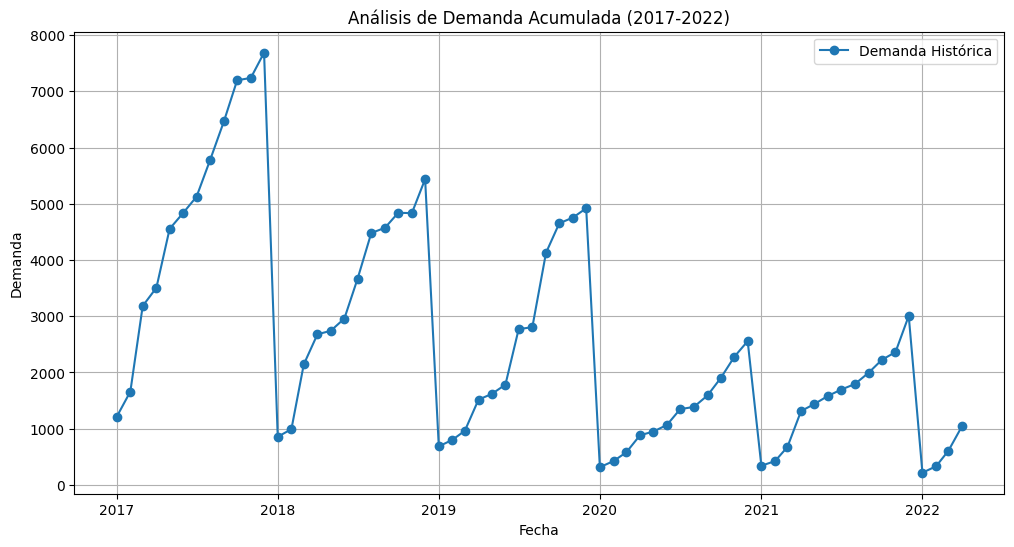

In [14]:
plt.figure(figsize=(12,6))
plt.plot(df_demand['Demand'], marker='o', label='Demanda Histórica')
plt.title('Análisis de Demanda Acumulada (2017-2022)')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.grid(True)
plt.legend()
plt.show()

### ***3. PREDICCIÓN SIMPLE (Siguiente mes)***

In [15]:
model_ts = ExponentialSmoothing(df_demand['Demand'], trend='add', seasonal=None).fit()
forecast = model_ts.forecast(3)

print(f"Demanda histórica promedio: {df_demand['Demand'].mean():.2f}")
print(f"Predicción demanda para el próximo mes: {forecast[0]:.2f}")

Demanda histórica promedio: 2600.04
Predicción demanda para el próximo mes: 1029.03


c:\Users\matecarr\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\matecarr\AppData\Local\Temp\ipykernel_27656\511812391.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Predicción demanda para el próximo mes: {forecast[0]:.2f}")


Pronóstico de demanda para los próximos 3 meses:
2022-05-01    1029.025607
2022-06-01    1029.585051
2022-07-01    1030.144496
Freq: MS, dtype: float64


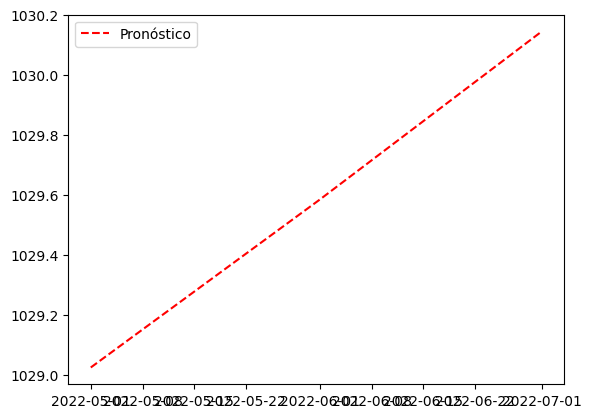

In [16]:
print("Pronóstico de demanda para los próximos 3 meses:")
print(forecast)

plt.plot(forecast, color='red', linestyle='--', label='Pronóstico')
plt.legend()
plt.show()